In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import subprocess


In [2]:
push_updates = True


## Simulate Games to calculate xP

Basic strategy: 

- simulate each shot N times
- sum each of those shots along the columns by event.id, by team
- compare sum by team by simulation
- calculate the probability the team wins the event by comparing % of matches wrt win, lose, draw

In [3]:
# import the shots dataset
shots = pd.read_csv("/Users/harrisonward/Desktop/CS/Git/xG/datasets/23_24_shotmaps_augmented.csv", index_col="Unnamed: 0")

In [4]:
# pull P(Goal) and match info
sim_df = shots[["xG", "team", "opponent", "event.id"]]

In [5]:
# find the number of sample, and the associated weights
N_samples = 10_000
shot_sim_weights = sim_df[["xG"]].values

In [6]:
# simulate each of the shots
shot_sim_matrix = np.random.binomial(
    1, shot_sim_weights.squeeze(), size=(N_samples, shot_sim_weights.shape[0])
)
shot_sim_matrix.shape

(10000, 1912)

In [7]:
# create column names for the simulated df and concat with match info
simulated_shots_df = pd.DataFrame(
    shot_sim_matrix.T,
    columns=[f"Simulation_{i+1}" for i in range(shot_sim_matrix.shape[0])],
)

simulated_shots_df = pd.concat(
    [simulated_shots_df, shots[["event.id", "team", "opponent"]]], axis=1
)
simulated_shots_df.head()

,Simulation_1,Simulation_2,Simulation_3,Simulation_4,Simulation_5,Simulation_6,Simulation_7,Simulation_8,Simulation_9,Simulation_10,...,Simulation_9994,Simulation_9995,Simulation_9996,Simulation_9997,Simulation_9998,Simulation_9999,Simulation_10000,event.id,team,opponent
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,11352251,Arsenal,Nottingham Forest
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,11352251,Nottingham Forest,Arsenal
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,11352251,Arsenal,Nottingham Forest
3,1,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,11352251,Arsenal,Nottingham Forest
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,11352251,Arsenal,Nottingham Forest


In [8]:
# sum each column by event, opponent and team; take the transpose
simulated_events_df = simulated_shots_df.groupby(["event.id", "team", "opponent"]).sum()
simulated_events_df_t = simulated_events_df.T
simulated_events_df_t.head()

event.id            11352250                          11352251  \
team             Bournemouth West Ham United           Arsenal   
opponent     West Ham United     Bournemouth Nottingham Forest   
Simulation_1               1               2                 3   
Simulation_2               1               2                 2   
Simulation_3               1               1                 4   
Simulation_4               2               1                 3   
Simulation_5               1               1                 2   

event.id                                     11352252                         \
team         Nottingham Forest Brighton & Hove Albion             Luton Town   
opponent               Arsenal             Luton Town Brighton & Hove Albion   
Simulation_1                 0                      4                      1   
Simulation_2                 1                      7                      2   
Simulation_3                 1                      3                      1   
Simulation_4                 1                      2                      3   
Simulation_5                 1                      3                      2   

event.id     11352253                 11352254                   ...  \
team          Everton  Fulham   Crystal Palace Sheffield United  ...   
opponent       Fulham Everton Sheffield United   Crystal Palace  ...   
Simulation_1        3       1                2                0  ...   
Simulation_2        3       1                3                0  ...   
Simulation_3        1       1                1                0  ...   
Simulation_4        2       2                2                0  ...   
Simulation_5        3       1                1                0  ...   

event.id             11352642                           11352643  \
team                  Burnley Newcastle United         Brentford   
opponent     Newcastle United          Burnley Nottingham Forest   
Simulation_1                0                4                 1   
Simulation_2                0                3                 1   
Simulation_3                0                2                 1   
Simulation_4                1                4                 1   
Simulation_5                0                4                 1   

event.id                                11352644                    \
team         Nottingham Forest         Liverpool Tottenham Hotspur   
opponent             Brentford Tottenham Hotspur         Liverpool   
Simulation_1                 1                 2                 1   
Simulation_2                 2                 1                 0   
Simulation_3                 1                 0                 3   
Simulation_4                 0                 0                 1   
Simulation_5                 1                 2                 2   

event.id             11352645                         11352646                  
team         Sheffield United  West Ham United Manchester City   Wolverhampton  
opponent      West Ham United Sheffield United   Wolverhampton Manchester City  
Simulation_1                1                2               0               0  
Simulation_2                2                2               0               1  
Simulation_3                1                2               1               0  
Simulation_4                0                1               0               0  
Simulation_5                0                4               1               0  

[5 rows x 138 columns]

In [9]:
# calculate possible outcomes for each event
simulated_results = []
for event_id, team, opponent in simulated_events_df_t.columns:
    simulated_results_dict = {
        "event.id": event_id,
        "team": team,
        "opponent": opponent,
        "results": np.array(
            simulated_events_df_t[event_id][team][opponent]
            - simulated_events_df_t[event_id][opponent][team]
        ),
    }

    simulated_results_dict["outcome_code"] = np.where(
        simulated_results_dict["results"] > 0, 1, -1
    )
    simulated_results_dict["outcome_code"] = np.where(
        simulated_results_dict["results"] == 0,
        0,
        simulated_results_dict["outcome_code"],
    )

    simulated_results_dict["win.pct"] = np.average(
        np.where(simulated_results_dict["outcome_code"] == 1, 1, 0)
    )
    simulated_results_dict["draw.pct"] = np.average(
        np.where(simulated_results_dict["outcome_code"] == 0, 1, 0)
    )

    simulated_results_dict["xP"] = (
        3 * simulated_results_dict["win.pct"] + 1 * simulated_results_dict["draw.pct"]
    )

    simulated_results.append(simulated_results_dict)

In [10]:
simulated_results_df = pd.DataFrame(simulated_results)
simulated_results_df.to_csv('/Users/harrisonward/Desktop/CS/Git/xG/assets/simulated_match_data.csv')
simulated_results_df.head()

,event.id,team,opponent,results,outcome_code,win.pct,draw.pct,xP
0,11352250,Bournemouth,West Ham United,"[-1, -1, 0, 1, 0, 1, -2, 0, 0, 1, 0, -1, 1, 0,...","[-1, -1, 0, 1, 0, 1, -1, 0, 0, 1, 0, -1, 1, 0,...",0.4237,0.3889,1.6600
1,11352250,West Ham United,Bournemouth,"[1, 1, 0, -1, 0, -1, 2, 0, 0, -1, 0, 1, -1, 0,...","[1, 1, 0, -1, 0, -1, 1, 0, 0, -1, 0, 1, -1, 0,...",0.1874,0.3889,0.9511
2,11352251,Arsenal,Nottingham Forest,"[3, 1, 3, 2, 1, 2, 3, 0, -1, 0, 2, 1, 0, 2, 2,...","[1, 1, 1, 1, 1, 1, 1, 0, -1, 0, 1, 1, 0, 1, 1,...",0.7006,0.2245,2.3263
3,11352251,Nottingham Forest,Arsenal,"[-3, -1, -3, -2, -1, -2, -3, 0, 1, 0, -2, -1, ...","[-1, -1, -1, -1, -1, -1, -1, 0, 1, 0, -1, -1, ...",0.0749,0.2245,0.4492
4,11352252,Brighton & Hove Albion,Luton Town,"[3, 5, 2, -1, 1, -1, 2, 2, 3, 0, 3, 2, 1, 3, 0...","[1, 1, 1, -1, 1, -1, 1, 1, 1, 0, 1, 1, 1, 1, 0...",0.9205,0.0673,2.8288


In [11]:
xp_table = (
    pd.DataFrame(simulated_results_df.groupby(by="team")["xP"].sum())
    .sort_values(by="xP", ascending=False)
    .reset_index()
)
xp_table.index = range(1, xp_table.shape[0] + 1)
xp_table["xP"] = xp_table["xP"].map("{:,.2f}".format).astype("float64")
xp_table = xp_table.rename(columns={"team": "Team"})

In [12]:
xg_table = pd.read_csv("/Users/harrisonward/Desktop/CS/Git/xG/assets/xG_table.csv", index_col="Unnamed: 0")

full_table = xg_table.merge(xp_table, how="outer", left_on="Team", right_on="Team")
full_table = full_table.sort_values(by="xP", ascending=False, inplace=False)
full_table.index = range(1, full_table.shape[0] + 1)

In [13]:
full_table.to_csv("/Users/harrisonward/Desktop/CS/Git/xG/assets/full_table.csv")
full_table.to_markdown("/Users/harrisonward/Desktop/CS/Git/xG/assets/full_table.md")
full_table.head(20)

,Team,xG,xGA,xG Differential,xP
1,Manchester City,13.84,2.90,10.94,17.47
2,Arsenal,14.05,5.66,8.39,15.69
3,Tottenham Hotspur,14.23,7.80,6.42,14.36
4,Aston Villa,14.79,9.35,5.43,13.19
5,Newcastle United,15.86,6.67,9.19,13.05
6,Liverpool,13.37,8.98,4.38,12.50
7,Brighton & Hove Albion,14.55,12.44,2.11,12.30
8,West Ham United,12.99,10.69,2.31,11.56
9,Crystal Palace,8.60,6.95,1.64,10.53
10,Chelsea,8.66,6.56,2.11,10.52


In [14]:
if push_updates:
    subprocess.run(
        ["/Users/harrisonward/Desktop/CS/Git/xG/scripts/push_assets.sh"])


[main ee854f3] Auto-commit all assets
 3 files changed, 178 insertions(+), 178 deletions(-)
 rewrite assets/full_table.csv (86%)
 rewrite assets/simulated_match_data.csv (98%)


remote: Bypassed rule violations for refs/heads/main:        
remote: 
remote: - Changes must be made through a pull request.        
remote: 
To https://github.com/Harrison-Ward/xG.git
   fdc52c2..ee854f3  main -> main


## Visualize select outcomes

In [15]:
def addlabels(x, y, vertical_bob):
    for i in range(len(x)):
        plt.text(i, y[i] + vertical_bob, f"{y[i]:.2f}", ha="center")

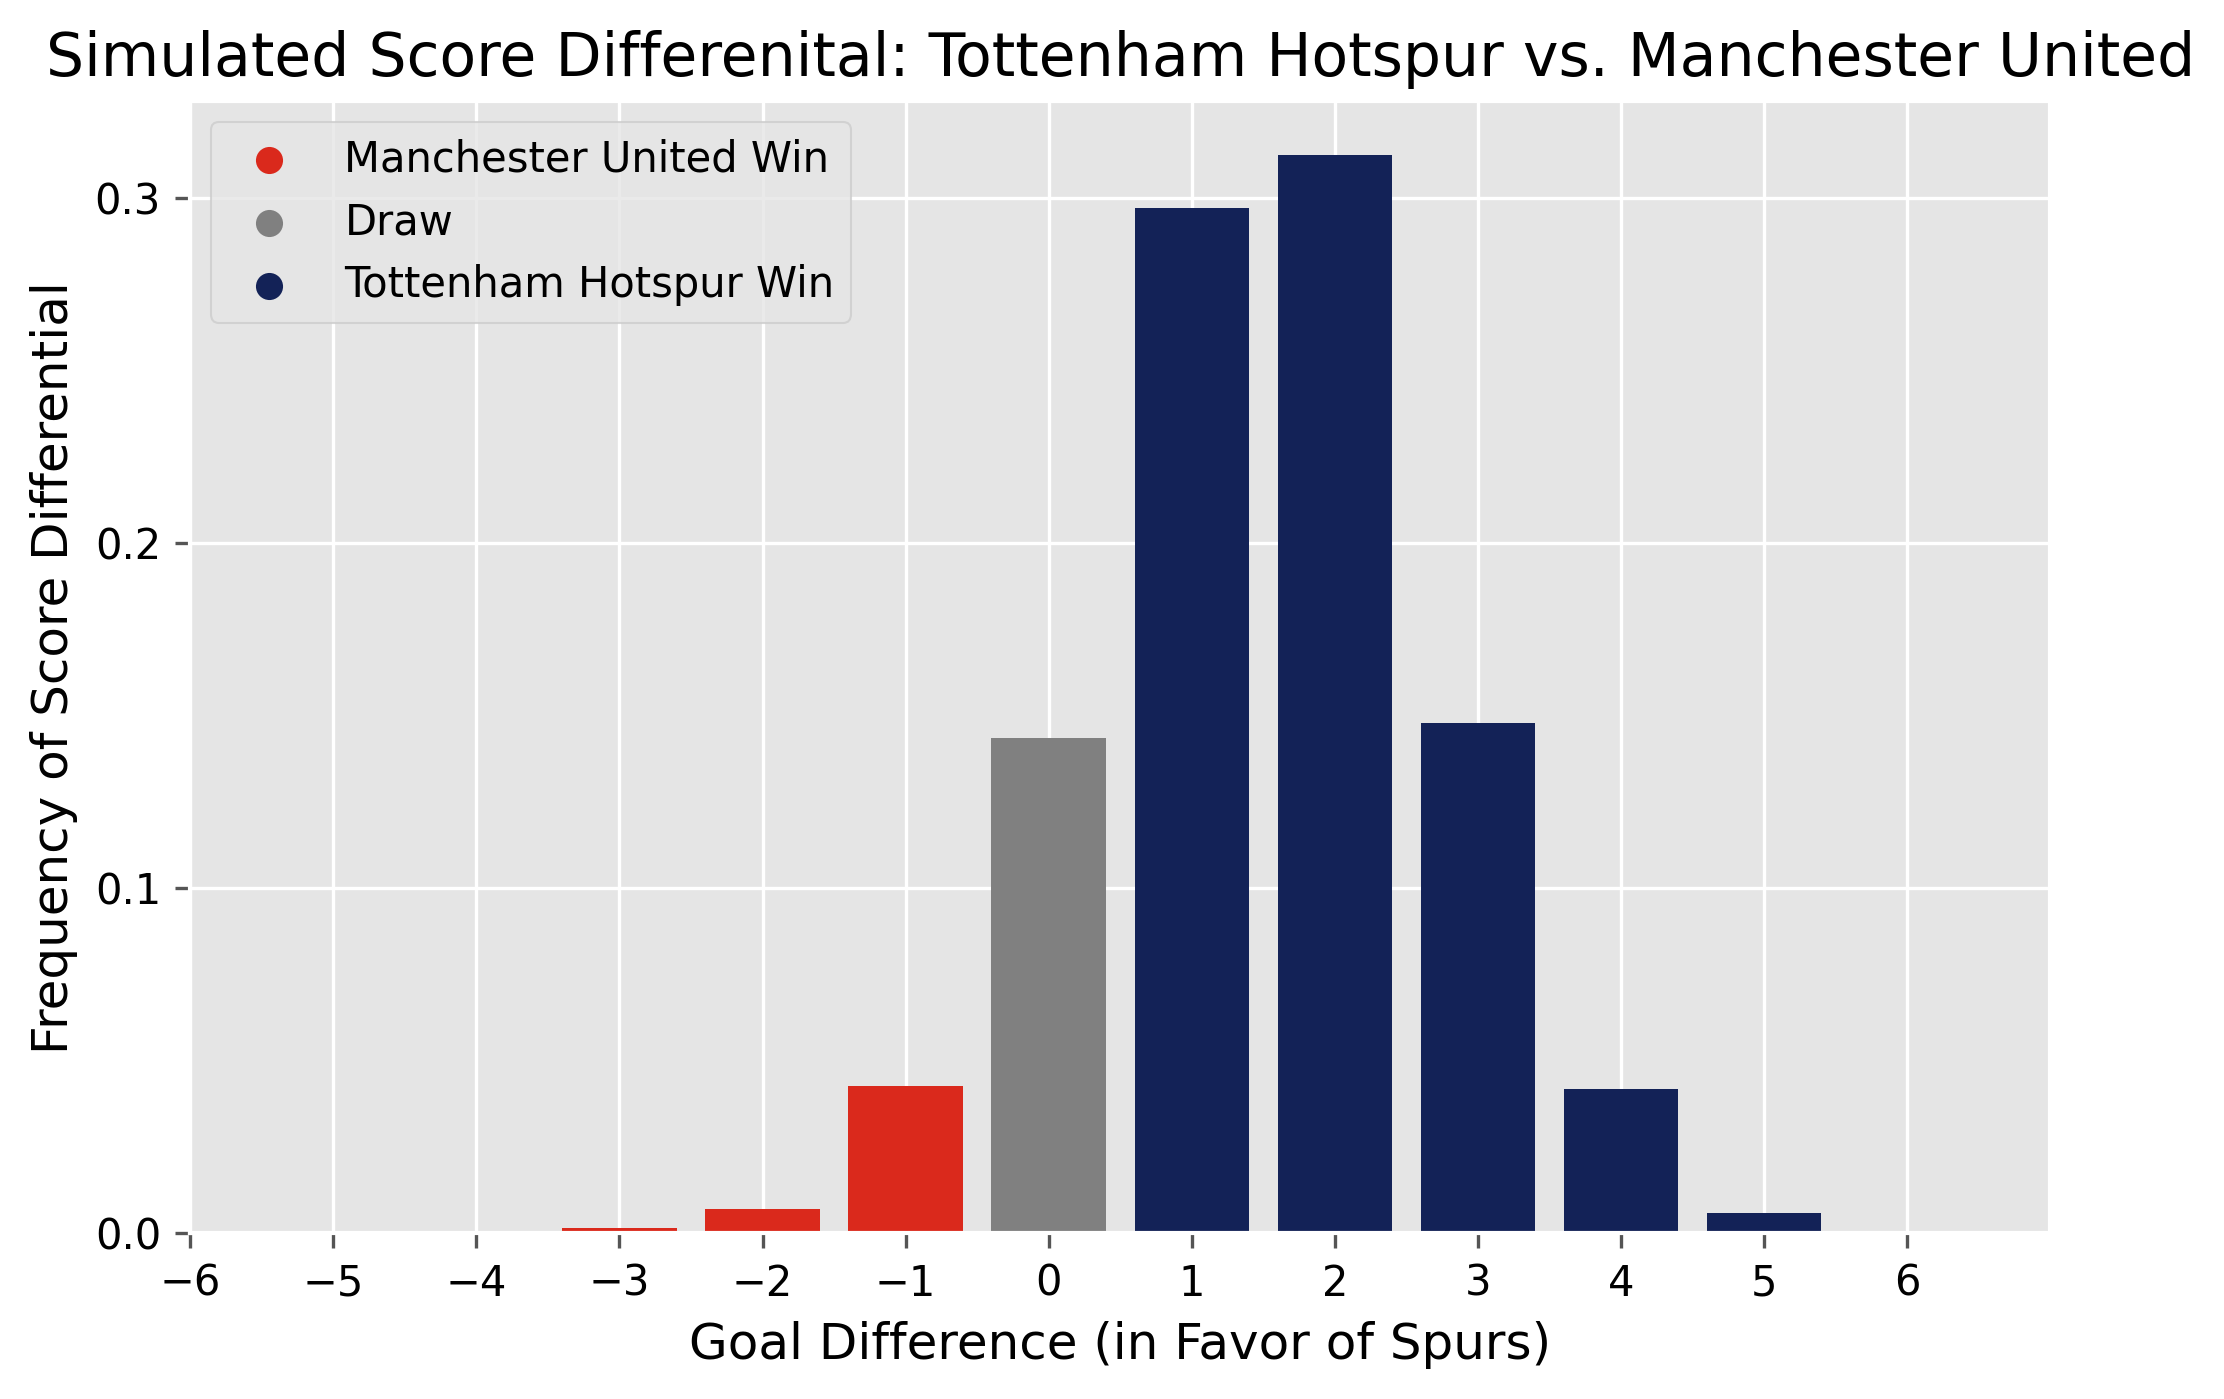

<Figure size 432x288 with 0 Axes>

In [19]:
tot_man_scores = (
    simulated_results_df.results[
        (simulated_results_df["team"].astype(str) == "Tottenham Hotspur")
        & (simulated_results_df["opponent"].astype(str) == "Manchester United")
    ]
    .values[0]
    .astype(float)
)


values, counts = np.unique(tot_man_scores, return_counts=True)
frequencies = counts / np.sum(counts)
x_bound = max(np.abs(values))
colors = np.where(values > 0, "#132257", "#DA291C")
colors = np.where(values == 0, "grey", colors)

plt.figure(figsize=(8, 5), dpi=300)
plt.style.use("ggplot")
plt.tick_params(left=True, right=False, labelleft=True, labelbottom=True, bottom=True)
plt.bar(values, frequencies, color=colors)
plt.scatter(None, None, color="#DA291C", label="Manchester United Win")
plt.scatter(None, None, color="grey", label="Draw")
plt.scatter(None, None, color="#132257", label="Tottenham Hotspur Win")
plt.title("Simulated Score Differenital: Tottenham Hotspur vs. Manchester United")
plt.xlabel("Goal Difference (in Favor of Spurs)", color="Black")
plt.ylabel("Frequency of Score Differential", color="Black")
plt.xticks(np.arange(-x_bound, x_bound), color="Black")
plt.yticks(np.arange(0, np.max(frequencies), step=0.1), color="Black")
plt.xlim(-x_bound + 1, x_bound)
plt.legend()
plt.savefig("/Users/harrisonward/Desktop/CS/Git/xG/assets/sim_score_diff.png")
plt.show()

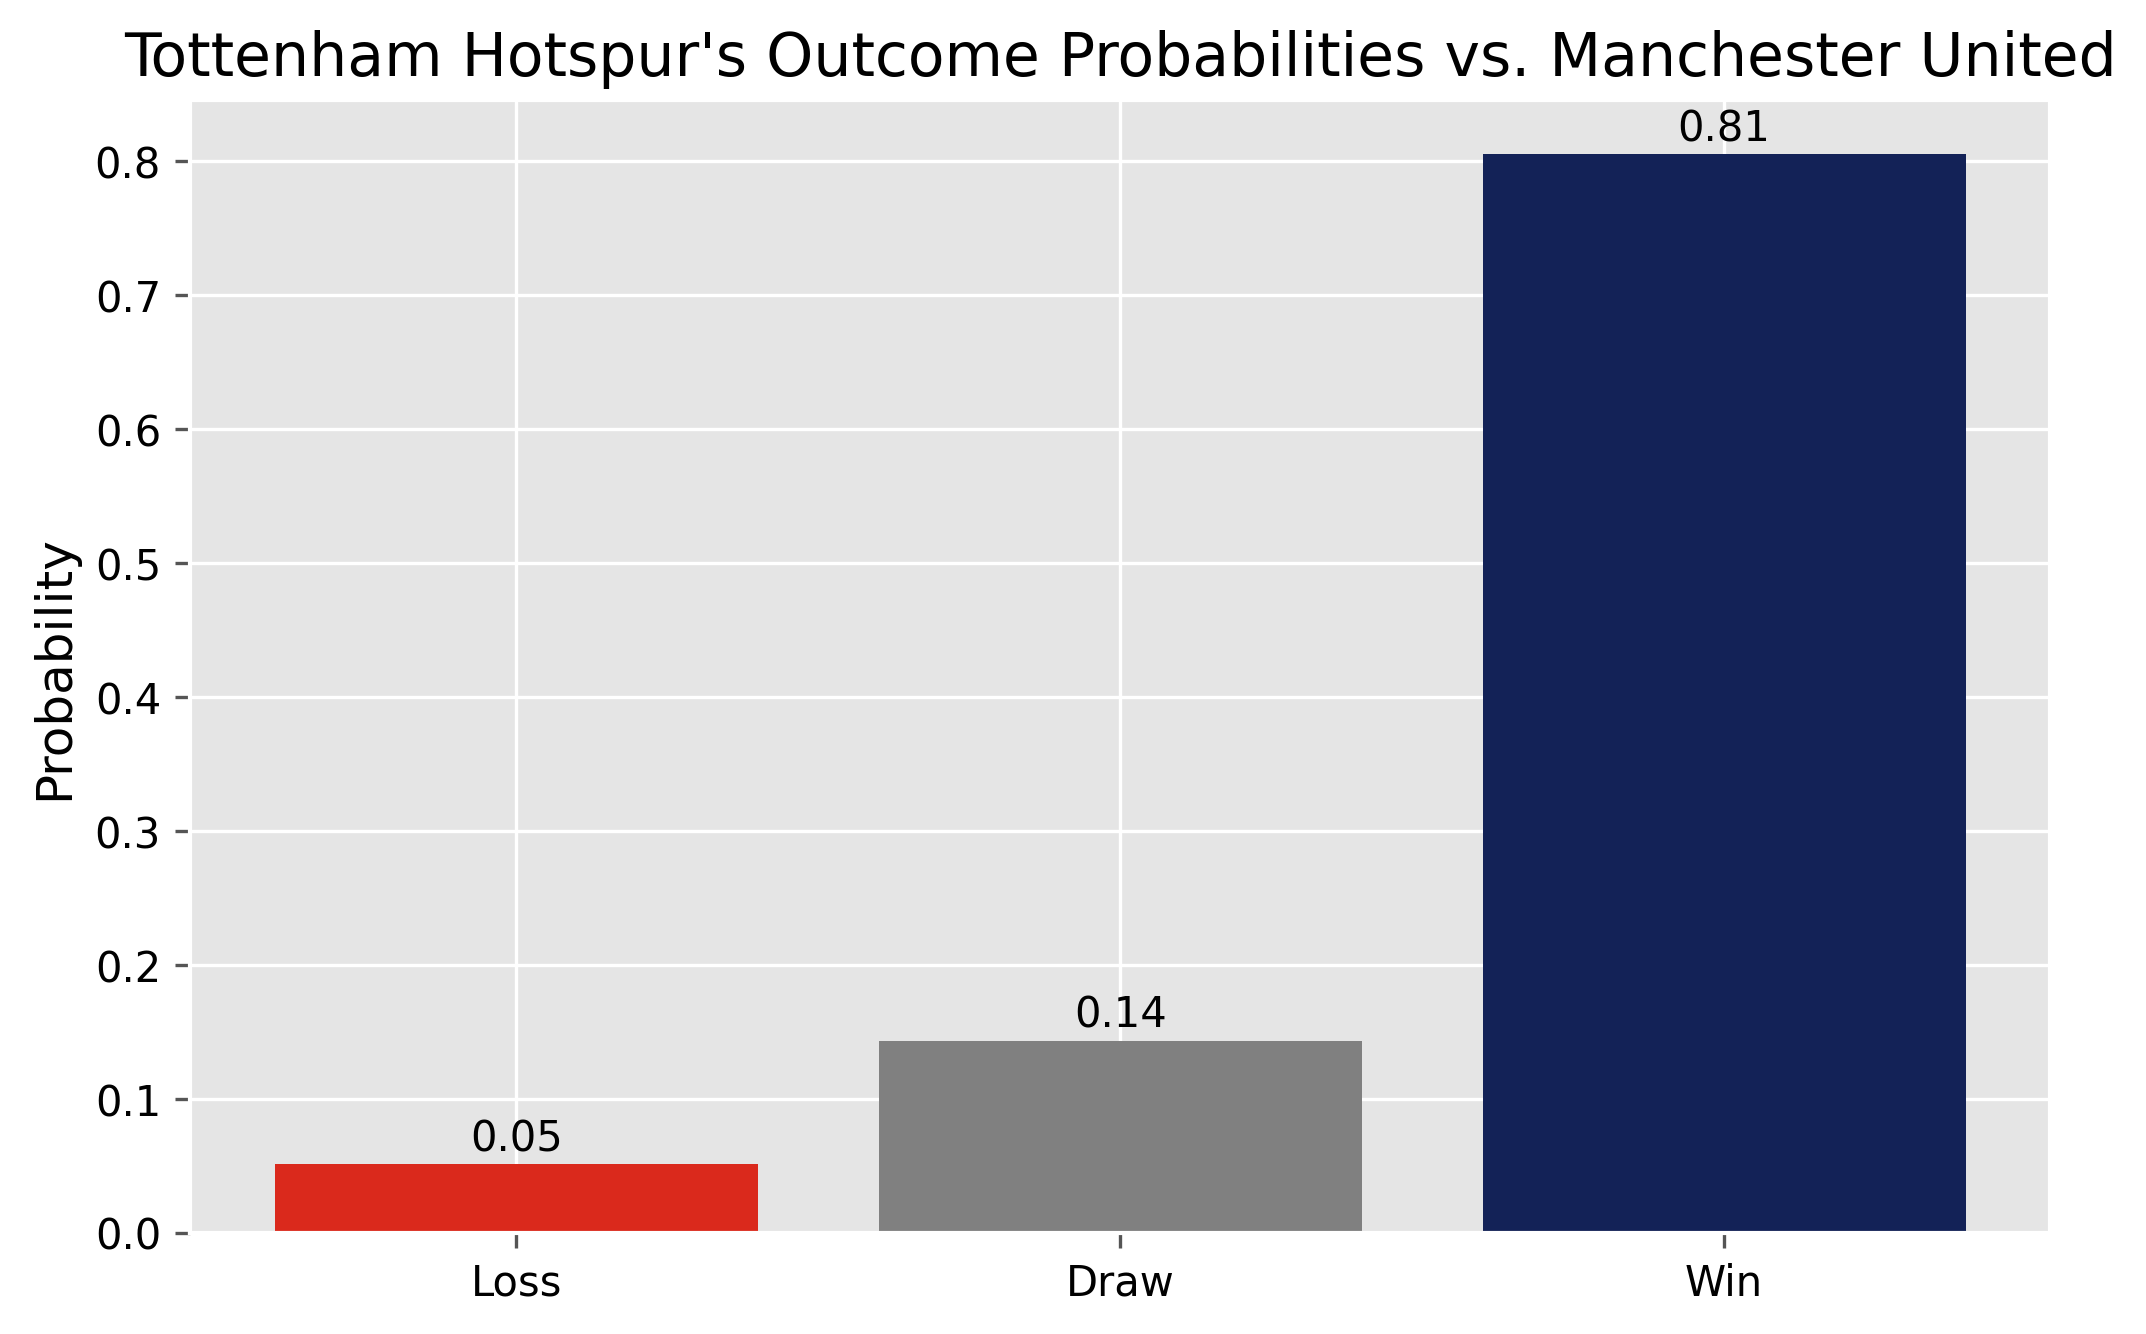

<Figure size 432x288 with 0 Axes>

In [20]:
outcome_probablities = simulated_results_df[["win.pct", "draw.pct"]][
    (simulated_results_df["team"].astype(str) == "Tottenham Hotspur")
    & (simulated_results_df["opponent"].astype(str) == "Manchester United")
].values
outcome_probablities = np.append(outcome_probablities, 1 - np.sum(outcome_probablities))
outcome_probablities = outcome_probablities[::-1]

colors = ["#DA291C", "grey", "#132257"]

plt.figure(figsize=(8, 5), dpi=300)
plt.style.use("ggplot")
x_axis = np.arange(outcome_probablities.shape[0])
plt.title("Tottenham Hotspur's Outcome Probabilities vs. Manchester United")
plt.bar(x_axis, outcome_probablities, color=colors)
addlabels(x_axis, outcome_probablities, 0.01)
plt.xticks(
    np.arange(outcome_probablities.shape[0]),
    labels=["Loss", "Draw", "Win"],
    color="black",
)
plt.yticks(color="black")
plt.ylabel("Probability", color="black")
plt.savefig("/Users/harrisonward/Desktop/CS/Git/xG/assets/sim_outcome_prob.png")
plt.show()

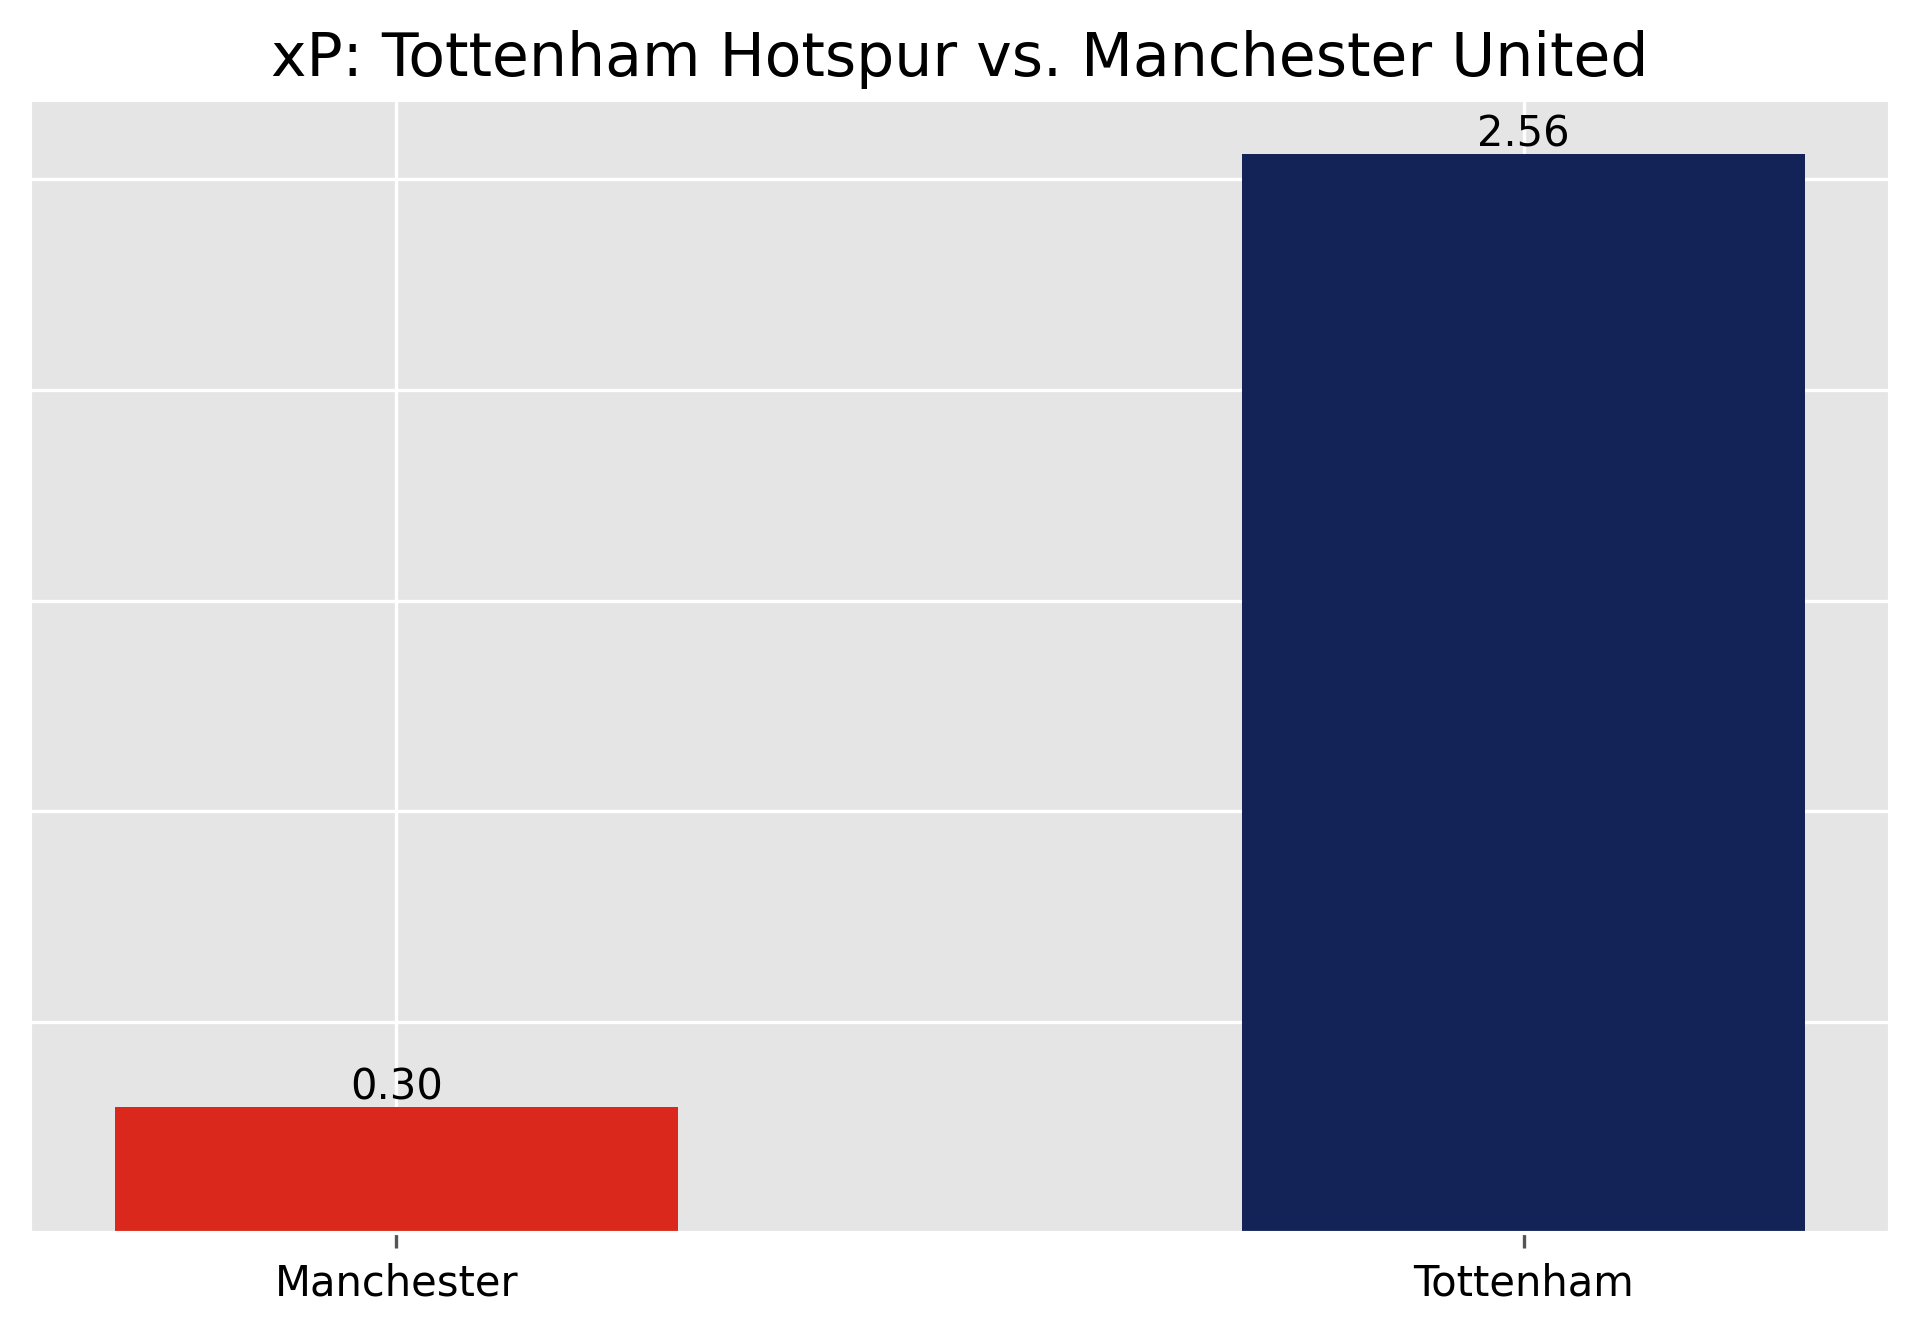

In [21]:
tot_xp = 3 * outcome_probablities[2] + 1 * outcome_probablities[1]
man_xp = 3 * outcome_probablities[0] + 1 * outcome_probablities[1]

colors = ["#DA291C", "#132257"]
plt.figure(figsize=(8, 5), dpi=300)
plt.style.use("ggplot")
plt.tick_params(left=False, right=False, labelleft=False, labelbottom=True, bottom=True)
plt.bar([0, 1], [man_xp, tot_xp], color=colors, width=0.5)
addlabels([0, 1], [man_xp, tot_xp], 0.02)
plt.title("xP: Tottenham Hotspur vs. Manchester United")
plt.xticks([0, 1], ["Manchester", "Tottenham"], color="Black")
plt.yticks(color="black")
plt.savefig("/Users/harrisonward/Desktop/CS/Git/xG/assets/sim_xp.png")
plt.show()